In [175]:
import os
import json
import random
import itertools
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import cartopy.crs as ccrs
import cartopy.feature as cf

from scipy.optimize import curve_fit

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down
from function import ART_preprocessing as ART_pre

In [176]:
# product, time_reso = 'ERA5', '1dy'
product, time_reso = 'IMERG', '1dy'

In [177]:
yy_s, yy_e = 2002, 2012
lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [178]:
json_read = f'../json/{product}_{time_reso}.json'

if os.path.exists(json_read):
    with open (json_read) as f:
        param = json.load(f)
else:
    raise SystemExit(f"File not found: {json_read}")

NEIBHR = 2*param['npix']+1

print(f'Read json file   : {json_read.split('/')[-1]}')
print(f'Number of threads: {param['BETA_cores']}')
print(f'Neighborhood area: {NEIBHR}x{NEIBHR}')
print()

Read json file   : IMERG_1dy.json
Number of threads: 22
Neighborhood area: 5x5



In [179]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')

In [180]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
    VENETO_DEM = gpd.read_file(os.path.join(veneto_dir,'Veneto_DEM_1000.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [181]:
print(f'Reading data: {param['file']}')
if product == 'SM2RAIN':
    dir_data = os.path.join(dir_base,product,'ASCAT',time_reso,param['file'])
else:
    dir_data = os.path.join(dir_base,product,time_reso,param['file'])

PRE_data = xr.open_dataset(dir_data)
PRE_data = PRE_data.sel(time=PRE_data.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    PRE_data = PRE_data.sel(lat=slice(lat_max+1, lat_min-1), lon=slice(lon_min-1, lon_max+1))
else:
    PRE_data = PRE_data.sel(lat=slice(lat_min-1, lat_max+1), lon=slice(lon_min-1, lon_max+1))

lats = PRE_data['lat'].data
lons = PRE_data['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon = np.size(lons)
nlat = np.size(lats)
ntime = len(PRE_data['time'])

year_vector = np.unique(pd.to_datetime(PRE_data['time']).year)

PRE_data

Reading data: IMERG_Italy_1dy_2000_06_01_2024_02_29.nc


<xarray.Dataset> Size: 72MB
Dimensions:  (time: 4018, lat: 45, lon: 50)
Coordinates:
  * time     (time) datetime64[ns] 32kB 2002-01-01 2002-01-02 ... 2012-12-31
  * lat      (lat) float64 360B 43.55 43.65 43.75 43.85 ... 47.75 47.85 47.95
  * lon      (lon) float32 200B 9.55 9.65 9.75 9.85 ... 14.15 14.25 14.35 14.45
Data variables:
    PRE      (time, lat, lon) float64 72MB ...
Attributes:
    description:  IMERG daily data for Italy region

In [182]:
# Extracting lat and lon points for Study area (VENETO)
if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    ds_veneto = PRE_data.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
else:
    ds_veneto = PRE_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

if time_reso == '3h':
    PRE_mean = ds_veneto.resample(time ='D').sum(dim='time', skipna=False).mean(dim='time', skipna=True)
elif time_reso == '1dy':
    PRE_mean = ds_veneto.mean(dim='time', skipna=True)
else:
    raise SystemExit(f"Time resolution not found: {time_reso}")

lat_ref = ds_veneto.lat.values
lon_ref = ds_veneto.lon.values

ndices_lat = np.where(np.isin(lats, lat_ref))[0]
ndices_lon = np.where(np.isin(lons, lon_ref))[0]

lon2d_ref, lat2d_ref = np.meshgrid(lon_ref, lat_ref)

del ds_veneto

PRE_mean

<xarray.Dataset> Size: 6kB
Dimensions:  (lat: 25, lon: 30)
Coordinates:
  * lat      (lat) float64 200B 44.55 44.65 44.75 44.85 ... 46.75 46.85 46.95
  * lon      (lon) float32 120B 10.55 10.65 10.75 10.85 ... 13.25 13.35 13.45
Data variables:
    PRE      (lat, lon) float64 6kB 2.096 2.118 2.118 ... 3.416 3.477 3.403

In [183]:
data_dir = os.path.join(dir_base,'3_DOWN','VENETO_DOWN_IMERG_1dy_2002_2012_npix_5.nc')
DATA = xr.open_dataset(data_dir)
lon2d_SA, lat2d_SA = np.meshgrid(DATA.lon.values, DATA.lat.values)
QUANTILE = DATA.Quantile.values[2,:,:]

Text(0.0, 1.0, 'Study Region (Red) and Extended Area (Blue)')

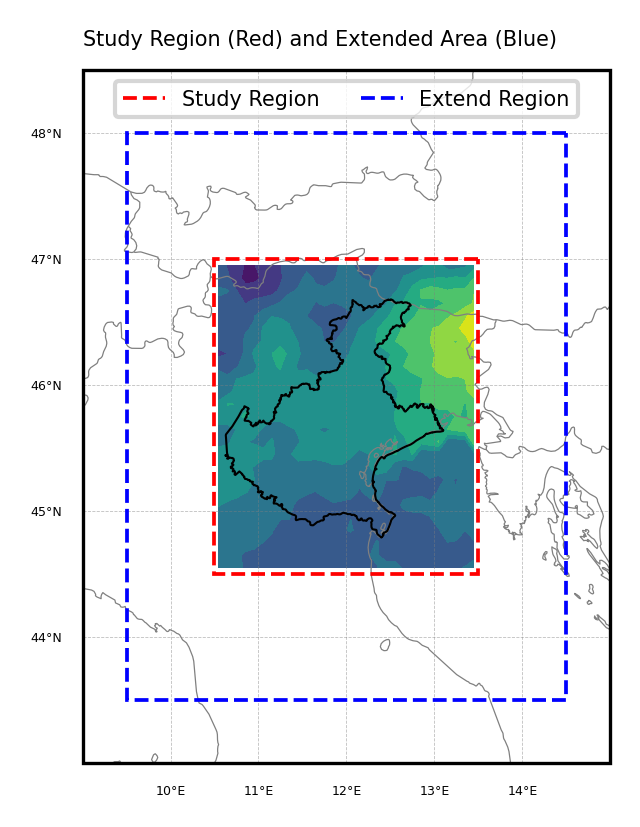

In [184]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(5,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min-1.5, lon_max+1.5, lat_min-1.5, lat_max+1.5],crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.3,color='grey')
ax1.add_feature(cf.BORDERS,linewidth=0.3,color='grey')
VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)

ax1.add_patch(patches.Rectangle((lon_max,lat_max),lon_min-lon_max,lat_min-lat_max,linestyle='--',linewidth=0.9,edgecolor='r',facecolor='None',zorder=5))
ax1.add_patch(patches.Rectangle((lon_max+1,lat_max+1),(lon_min-1)-(lon_max+1),(lat_min-1)-(lat_max+1),linestyle='--',linewidth=0.9,edgecolor='b',facecolor='None',zorder=5))

a1 = ax1.contourf(lon2d_ref, lat2d_ref, QUANTILE)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

ax1.plot([],[],linestyle='--',linewidth=0.9,color='r', label='Study Region')
ax1.plot([],[],linestyle='--',linewidth=0.9,color='b', label='Extend Region')

ax1.legend(fontsize=5,ncols=2,loc='upper center')
ax1.set_title('Study Region (Red) and Extended Area (Blue)', loc='left', fontsize=5)

In [185]:
lon2d_SR, lat2d_SR = np.meshgrid(lons[ndices_lon], lats[ndices_lat])

In [186]:
combinaciones = []
for lat in ndices_lat:
    for lon in ndices_lon:
        combinaciones.append((int(lat), int(lon)))

combination_DOWN = []
for la in range(len(ndices_lat)):
    for lo in range(len(ndices_lon)):
        combination_DOWN.append((int(la), int(lo)))

In [191]:
thread = 10

In [192]:
colors = plt.cm.tab10(np.linspace(0, 1, thread))

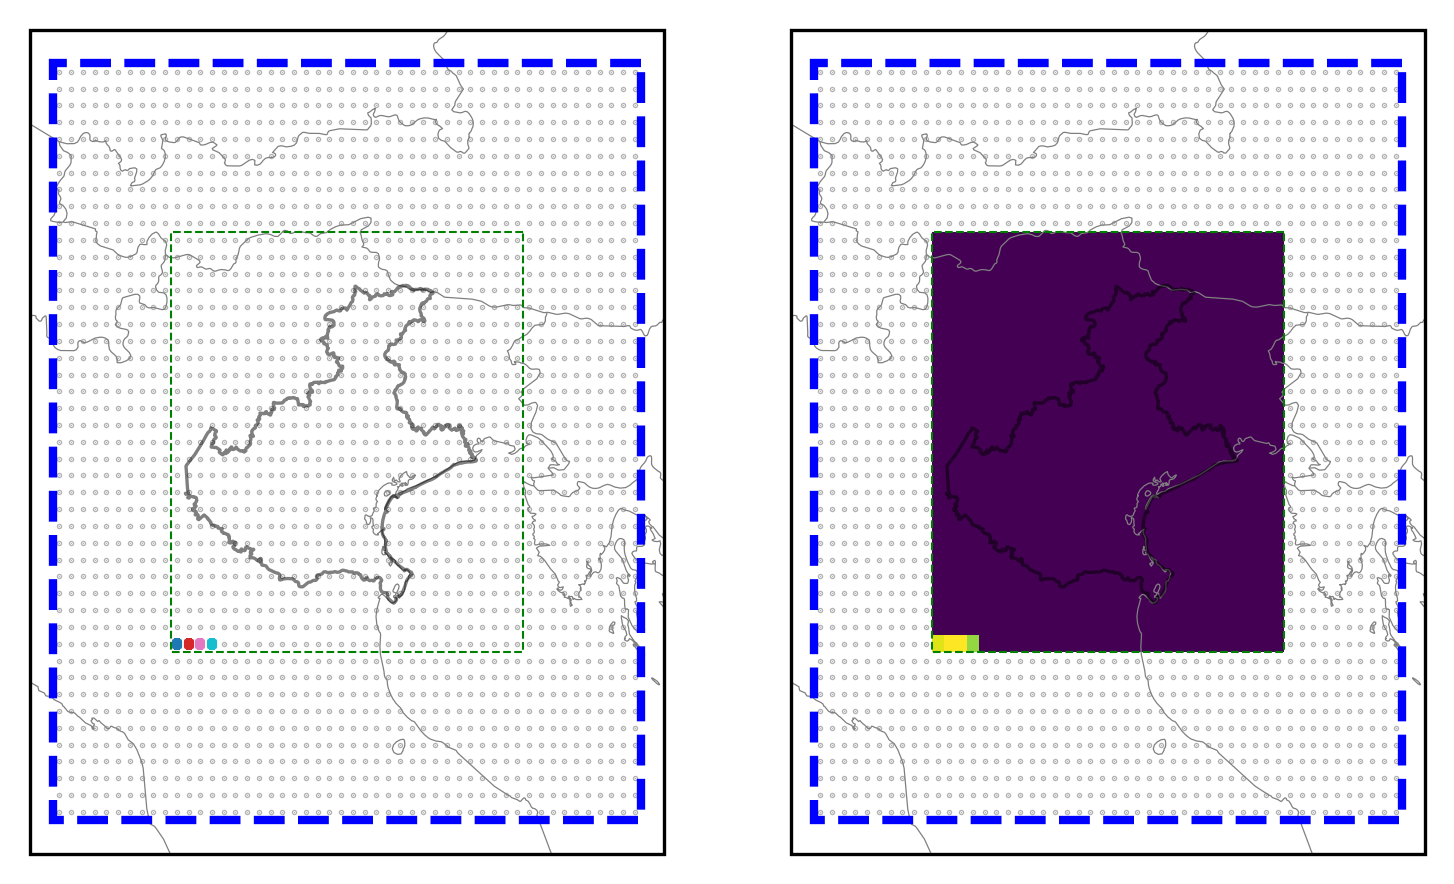

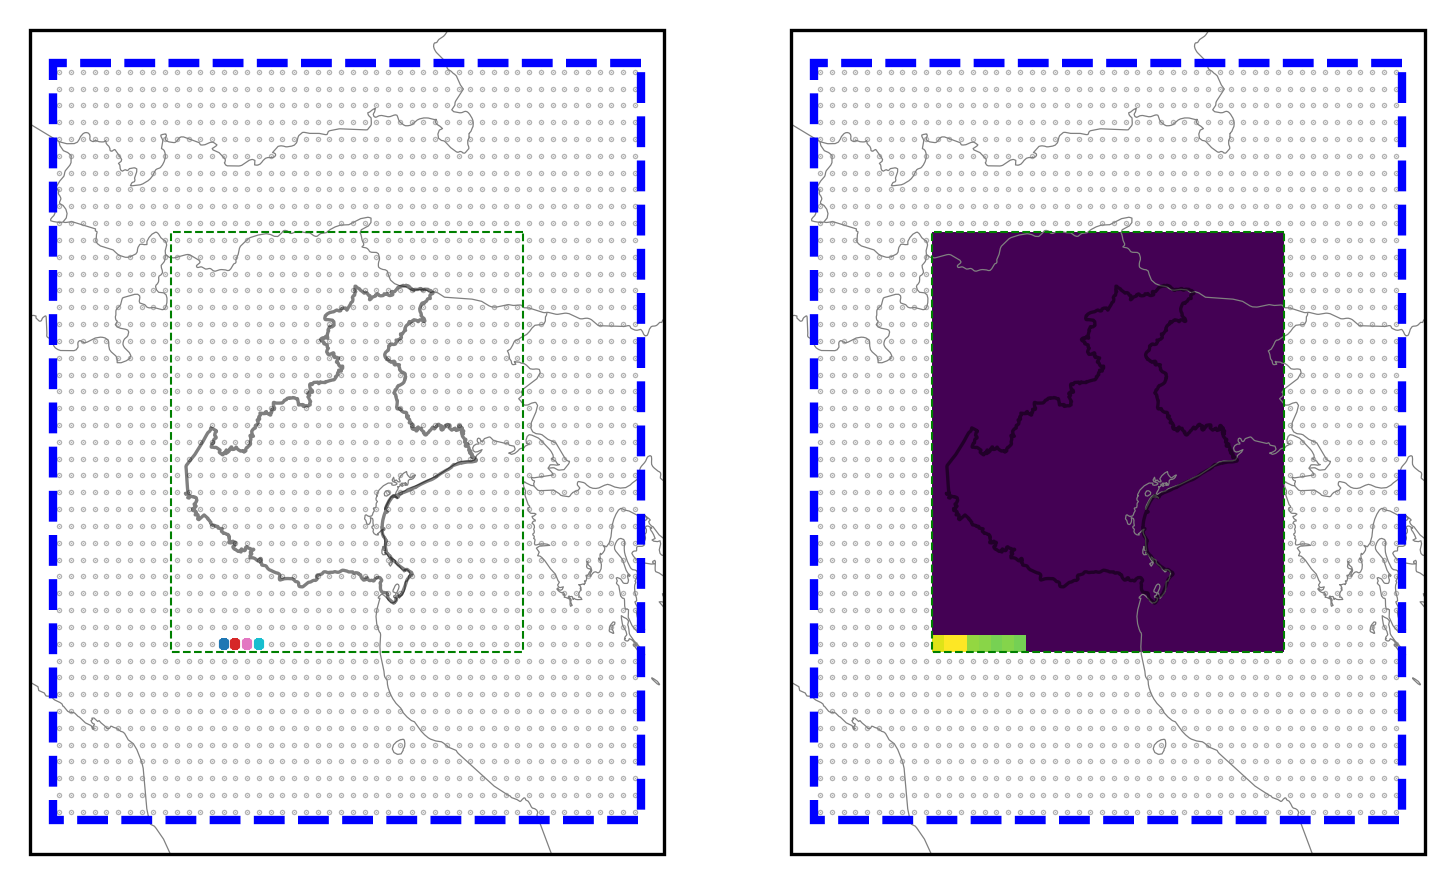

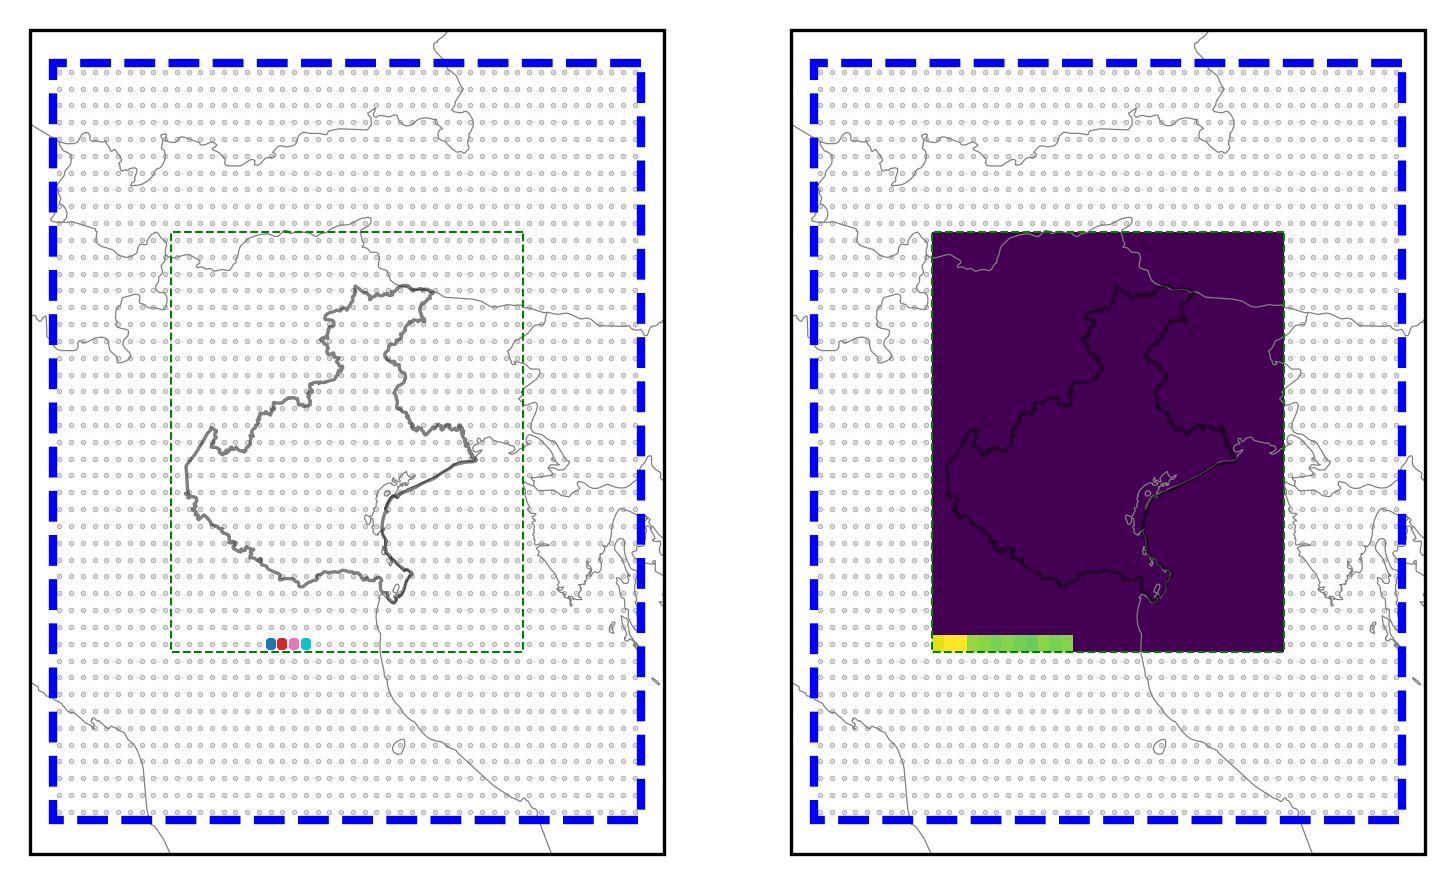

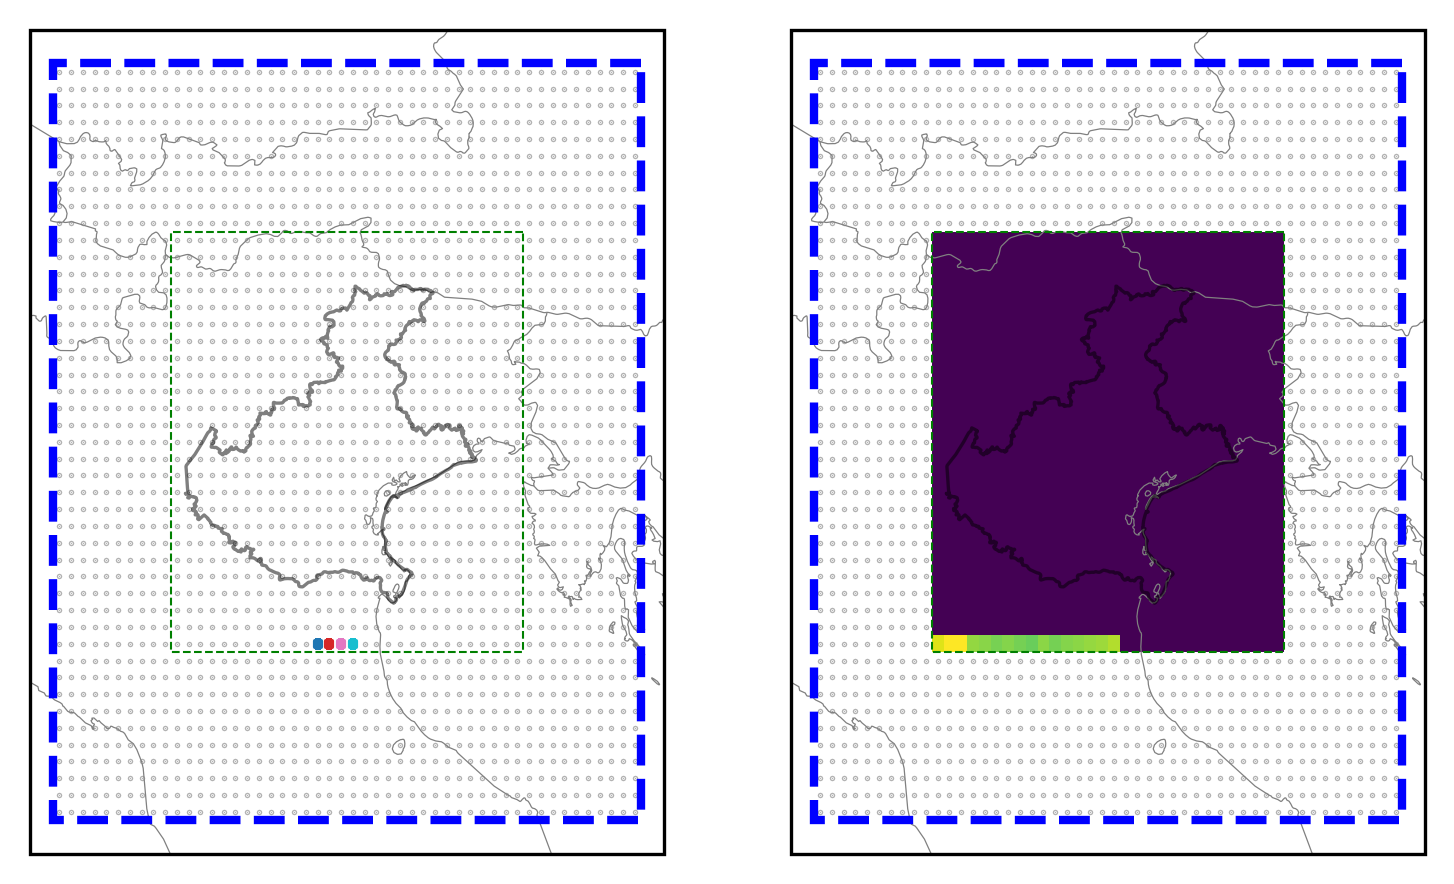

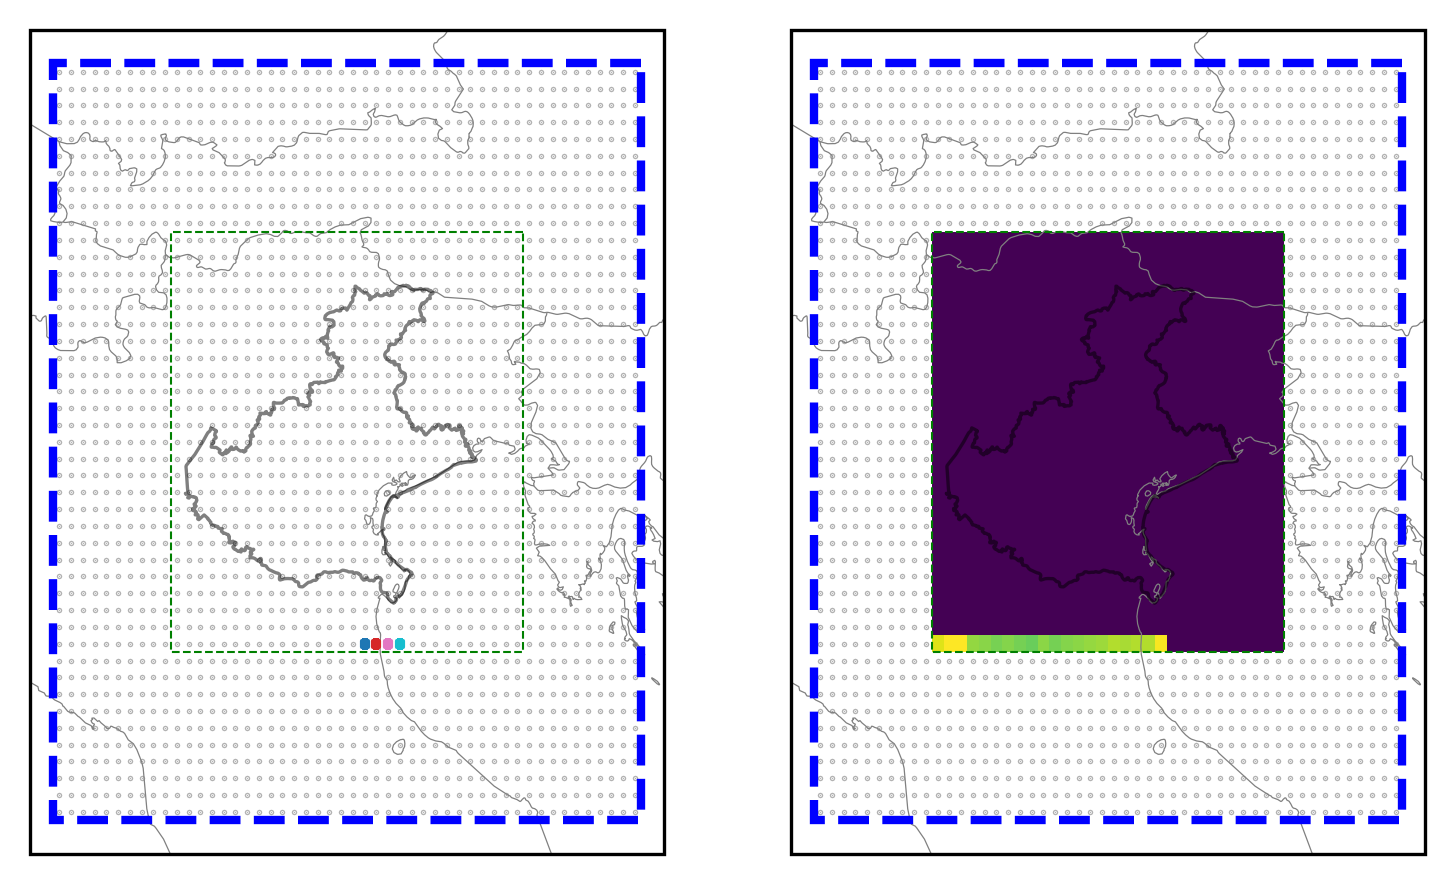

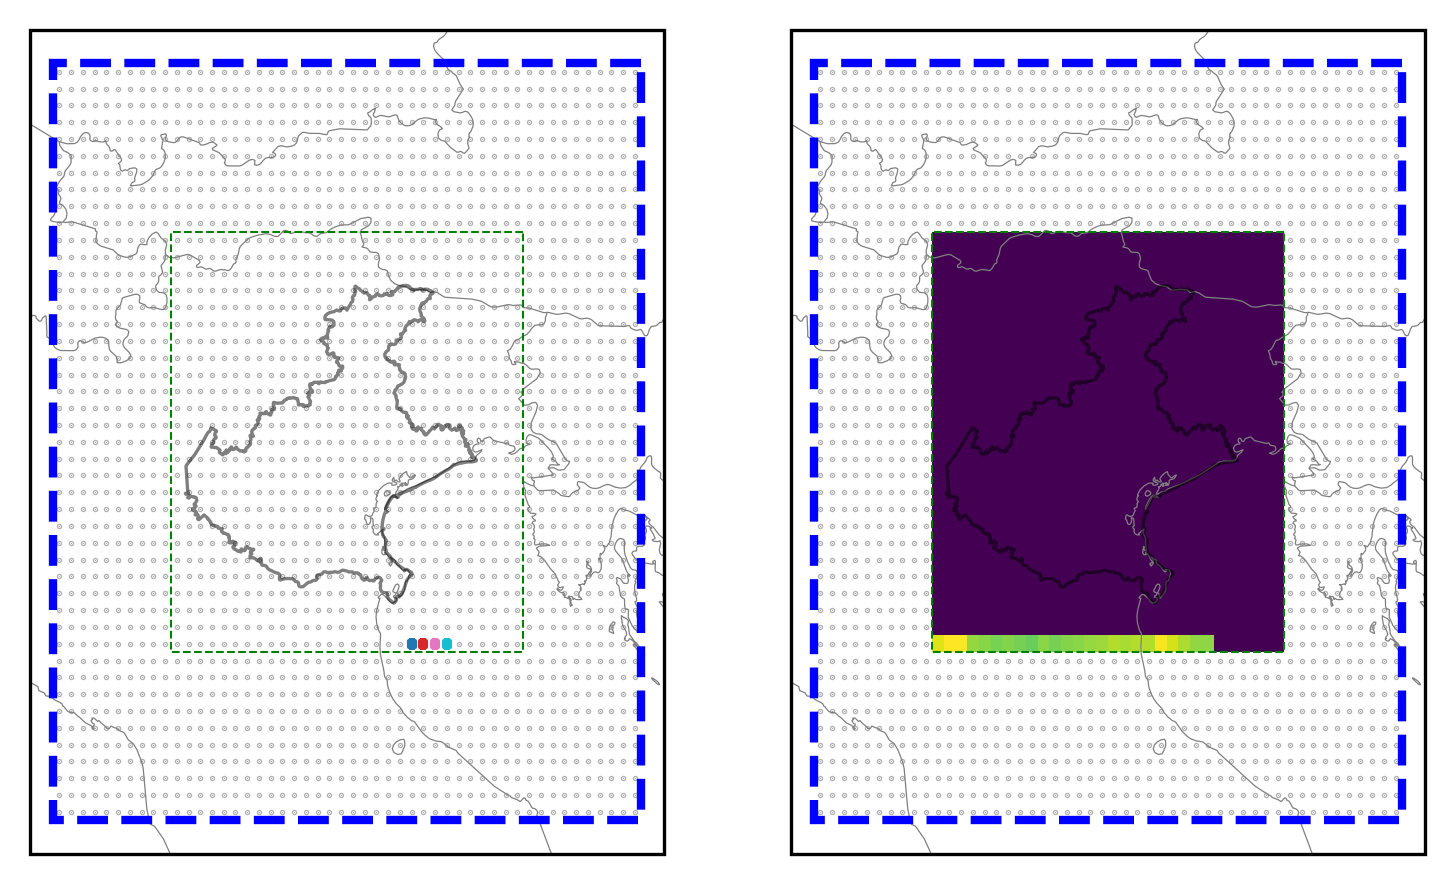

In [ ]:
ZEROS = np.zeros_like(QUANTILE)

for i in range(0, len(combinaciones[0:24]), thread):
    group = combinaciones[i:i+thread]
    lat_c1 = lats[group[0][0]]
    lon_c1 = lons[group[0][1]]

    if len(group) >= 2:
        lat_c2 = lats[group[1][0]]
        lon_c2 = lons[group[1][1]]

    if len(group) >= 3:
        lat_c3 = lats[group[2][0]]
        lon_c3 = lons[group[2][1]]

    if len(group) >= 4:
        lat_c4 = lats[group[3][0]]
        lon_c4 = lons[group[3][1]]

    group_down = combination_DOWN[i:i+thread]
    ZEROS[group_down[0][0],group_down[0][1]] = QUANTILE[group_down[0][0],group_down[0][1]]
    ZEROS[group_down[1][0],group_down[1][1]] = QUANTILE[group_down[1][0],group_down[1][1]]
    ZEROS[group_down[2][0],group_down[2][1]] = QUANTILE[group_down[2][0],group_down[2][1]]

    if len(group_down) >= 4:
        ZEROS[group_down[3][0],group_down[3][1]] = QUANTILE[group_down[3][0],group_down[3][1]]

    cmap = plt.cm.Spectral_r
    proj = ccrs.PlateCarree()

    fig = plt.figure(figsize=(6,4),dpi=300)
    gs = gridspec.GridSpec(1,2)
    
    # ============================================================================================================================
    ax1 = plt.subplot(gs[0, 0], projection = proj)
    ax1.set_extent([lon_min-1.2, lon_max+1.2, lat_min-1.2, lat_max+1.2],crs=proj)
    ax1.add_feature(cf.COASTLINE,linewidth=0.3,color='grey')
    ax1.add_feature(cf.BORDERS,linewidth=0.3,color='grey')
    VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.8, alpha=0.5)
    ax1.add_patch(patches.Rectangle((lon_max,lat_max),lon_min-lon_max,lat_min-lat_max,linestyle='--',linewidth=0.5,edgecolor='g',facecolor='None',zorder=5))
    ax1.add_patch(patches.Rectangle((lon_max+1,lat_max+1),(lon_min-1)-(lon_max+1),(lat_min-1)-(lat_max+1),linestyle='--',linewidth=2,edgecolor='b',facecolor='None',zorder=5))

    ax1.scatter(lon2d, lat2d, s=0.1, c='k', marker='o', alpha=0.3, label='Extended pixels')
    # ax1.scatter(lon2d_SR, lat2d_SR, s=0.5, c='g', marker='o', label='Study pixels')

    ax1.scatter(lon_c1, lat_c1, s=2 , c=colors[0], marker='s', zorder=55)
    ax1.scatter(lon_c2, lat_c2, s=2 , c=colors[1], marker='s', zorder=55)
    ax1.scatter(lon_c3, lat_c3, s=2 , c=colors[2], marker='s', zorder=55)
    ax1.scatter(lon_c4, lat_c4, s=2 , c=colors[3], marker='s', zorder=55)

    # ============================================================================================================================
    ax1 = plt.subplot(gs[0, 1], projection = proj)
    ax1.set_extent([lon_min-1.2, lon_max+1.2, lat_min-1.2, lat_max+1.2],crs=proj)
    ax1.add_feature(cf.COASTLINE,linewidth=0.3,color='grey')
    ax1.add_feature(cf.BORDERS,linewidth=0.3,color='grey')
    VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.8, alpha=0.5)
    ax1.add_patch(patches.Rectangle((lon_max,lat_max),lon_min-lon_max,lat_min-lat_max,linestyle='--',linewidth=0.5,edgecolor='g',facecolor='None',zorder=5))
    ax1.add_patch(patches.Rectangle((lon_max+1,lat_max+1),(lon_min-1)-(lon_max+1),(lat_min-1)-(lat_max+1),linestyle='--',linewidth=2,edgecolor='b',facecolor='None',zorder=5))

    ax1.scatter(lon2d, lat2d, s=0.1, c='k', marker='o', alpha=0.3, label='Extended pixels')
    ax1.pcolormesh(lon2d_SA, lat2d_SA, ZEROS)

    # plt.close()

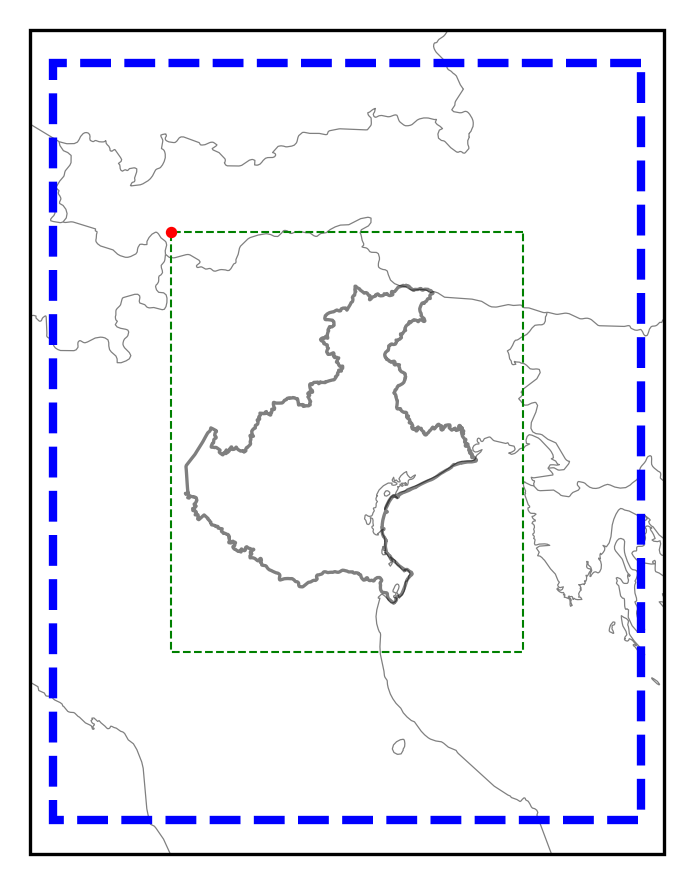

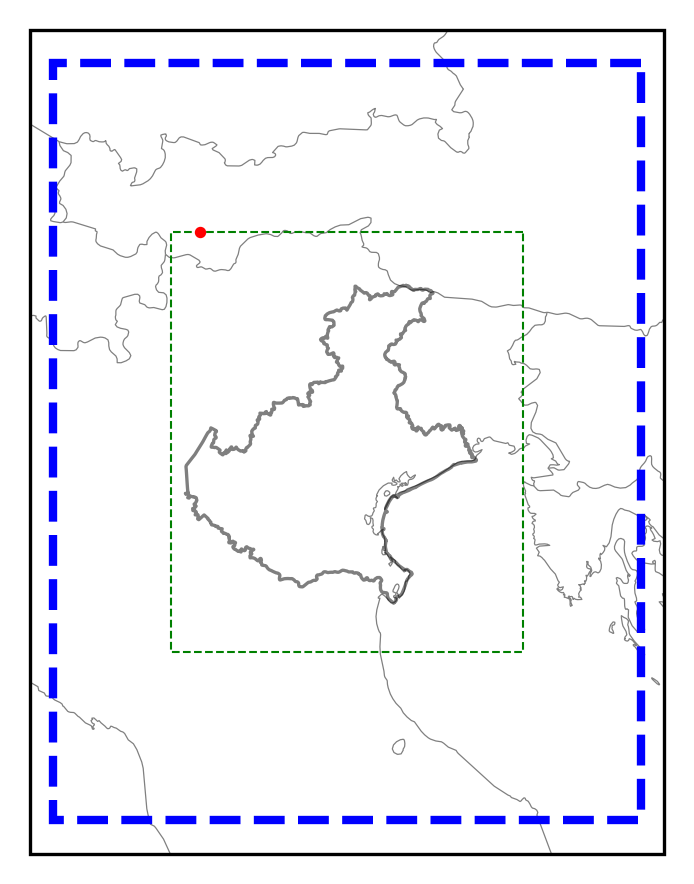

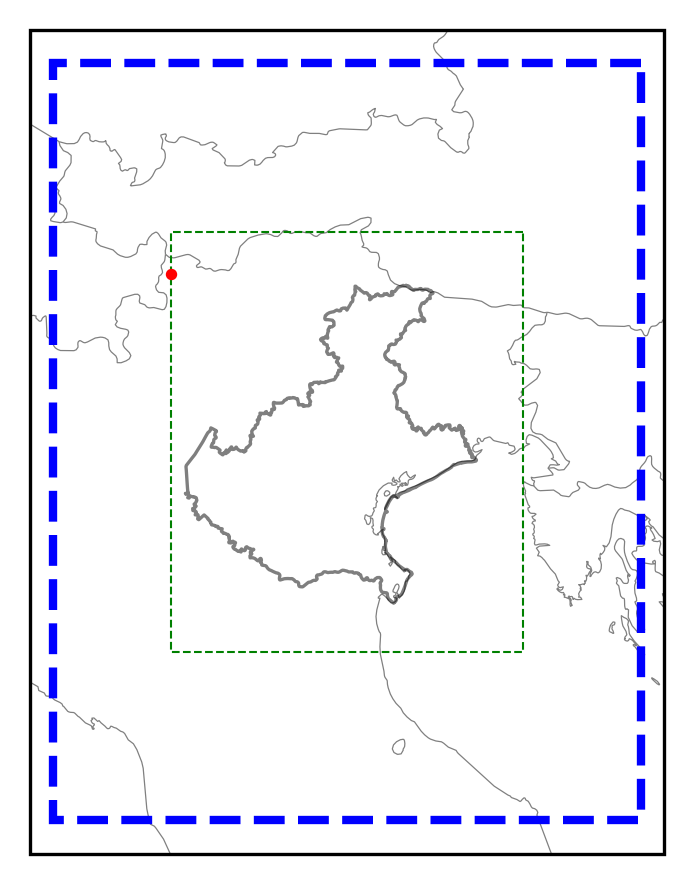

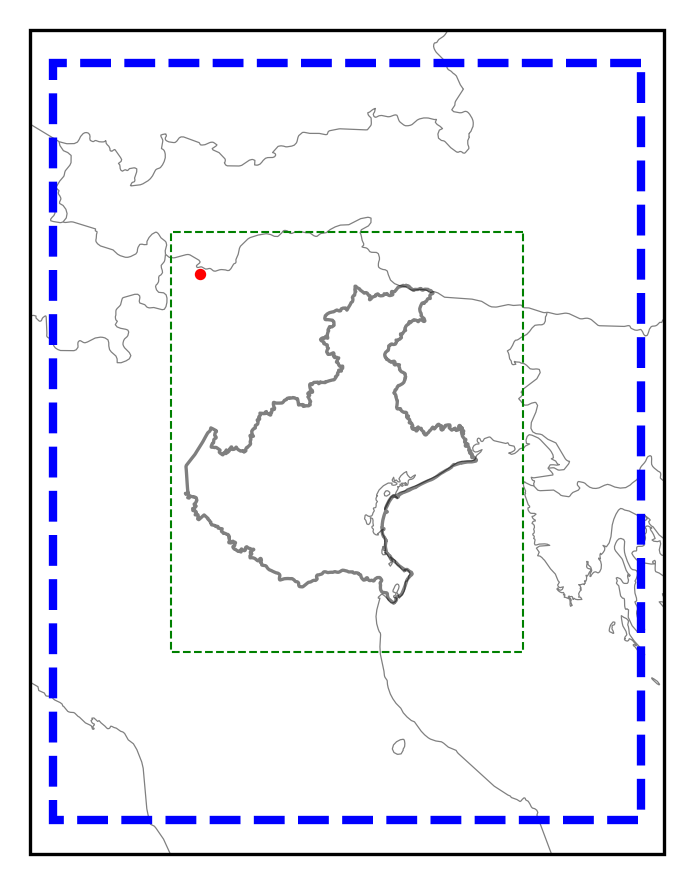

In [ ]:
# nn = 0
# for i in range(2):#len(ndices_lat)
#     for j in range(2):#len(ndices_lon)
#         lat_c1 = lats[ndices_lat[i]]
#         lon_c1 = lons[ndices_lon[j]]
        
#         lat_c2 = lats[ndices_lat[i]]
#         lon_c2 = lons[ndices_lon[j]]
        
#         lat_c3 = lats[ndices_lat[i]]
#         lon_c3 = lons[ndices_lon[j]]
        
#         lat_c4 = lats[ndices_lat[i]]
#         lon_c4 = lons[ndices_lon[j]]
        
#         # PRE_daily = PRE_data.resample(time ='D').sum(dim='time', skipna=False)
#         # BOX = ART_pre.create_box_v2(PRE_daily, lat_c, lon_c, 2)
#         # lat_box = BOX['lat'].data
#         # lon_box = BOX['lon'].data
#         # box_lon2d, box_lat2d = np.meshgrid(lon_box, lat_box)

#         # mask = np.full(lat2d.shape, False, dtype=bool)
#         # for la, lo in itertools.product(lat_box, lon_box):
#         #     mask[(lat2d == la) & (lon2d == lo)] = True

#         # cmap_bin = plt.get_cmap('viridis', 3)  # Use any colormap you like with 2 discrete levels
#         # norm = mcolors.BoundaryNorm([0, 0.5, 1], cmap_bin.N)  

#         cmap = plt.cm.Spectral_r
#         proj = ccrs.PlateCarree()

#         fig = plt.figure(figsize=(6,4),dpi=300)
#         gs = gridspec.GridSpec(2,2)
        
#         # ============================================================================================================================
#         ax1 = plt.subplot(gs[0:, 0], projection = proj)
#         ax1.set_extent([lon_min-1.2, lon_max+1.2, lat_min-1.2, lat_max+1.2],crs=proj)
#         ax1.add_feature(cf.COASTLINE,linewidth=0.3,color='grey')
#         ax1.add_feature(cf.BORDERS,linewidth=0.3,color='grey')
#         VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.8, alpha=0.5)
#         ax1.add_patch(patches.Rectangle((lon_max,lat_max),lon_min-lon_max,lat_min-lat_max,linestyle='--',linewidth=0.5,edgecolor='g',facecolor='None',zorder=5))
#         ax1.add_patch(patches.Rectangle((lon_max+1,lat_max+1),(lon_min-1)-(lon_max+1),(lat_min-1)-(lat_max+1),linestyle='--',linewidth=2,edgecolor='b',facecolor='None',zorder=5))
        
#         # a1 = ax1.pcolormesh(lon2d, lat2d, mask, cmap=cmap_bin, norm=norm)
        
#         # ax1.scatter(lon2d, lat2d, s=0.1, c='k', marker='o', label='Extended pixels')
#         # ax1.scatter(lon2d_SR, lat2d_SR, s=0.5, c='g', marker='o', label='Study pixels')
        
#         # ax1.scatter(box_lon2d, box_lat2d, s=0.5, c='b', label='Box pixels', zorder=50)
#         ax1.scatter(lon_c, lat_c, s=3 , c='r', label='Central pixel', zorder=55)

In [ ]:
# # RANDO CHOOSE
# random.shuffle(combinaciones)
# for i in range(0, len(combinaciones), 8):
#     group = combinaciones[i:i+8]
#     lat_c1 = lats[group[0][0]]
#     lon_c1 = lons[group[0][1]]
    
#     lat_c2 = lats[group[1][0]]
#     lon_c2 = lons[group[1][1]]
    
#     lat_c3 = lats[group[2][0]]
#     lon_c3 = lons[group[2][1]]
    
#     lat_c4 = lats[group[3][0]]
#     lon_c4 = lons[group[3][1]]
    
#     lat_c5 = lats[group[4][0]]
#     lon_c5 = lons[group[4][1]]
    
#     lat_c6 = lats[group[5][0]]
#     lon_c6 = lons[group[5][1]]
    
#     lat_c7 = lats[group[6][0]]
#     lon_c7 = lons[group[6][1]]
    
#     if len(group) >= 8:
#         lat_c8 = lats[group[7][0]]
#         lon_c8 = lons[group[7][1]]
    
#     cmap = plt.cm.Spectral_r
#     proj = ccrs.PlateCarree()

#     fig = plt.figure(figsize=(6,4),dpi=300)
#     gs = gridspec.GridSpec(2,2)
    
#     # ============================================================================================================================
#     ax1 = plt.subplot(gs[0:, 0], projection = proj)
#     ax1.set_extent([lon_min-1.2, lon_max+1.2, lat_min-1.2, lat_max+1.2],crs=proj)
#     ax1.add_feature(cf.COASTLINE,linewidth=0.3,color='grey')
#     ax1.add_feature(cf.BORDERS,linewidth=0.3,color='grey')
#     VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.8, alpha=0.5)
#     ax1.add_patch(patches.Rectangle((lon_max,lat_max),lon_min-lon_max,lat_min-lat_max,linestyle='--',linewidth=0.5,edgecolor='g',facecolor='None',zorder=5))
#     ax1.add_patch(patches.Rectangle((lon_max+1,lat_max+1),(lon_min-1)-(lon_max+1),(lat_min-1)-(lat_max+1),linestyle='--',linewidth=2,edgecolor='b',facecolor='None',zorder=5))
    
#     ax1.scatter(lon_c1, lat_c1, s=3 , c=colors[0], marker='s', zorder=55)
#     ax1.scatter(lon_c2, lat_c2, s=3 , c=colors[1], marker='s', zorder=55)
#     ax1.scatter(lon_c3, lat_c3, s=3 , c=colors[2], marker='s', zorder=55)
#     ax1.scatter(lon_c4, lat_c4, s=3 , c=colors[3], marker='s', zorder=55)
#     ax1.scatter(lon_c5, lat_c5, s=3 , c=colors[4], marker='s', zorder=55)
#     ax1.scatter(lon_c6, lat_c6, s=3 , c=colors[5], marker='s', zorder=55)
#     ax1.scatter(lon_c7, lat_c7, s=3 , c=colors[6], marker='s', zorder=55)
#     ax1.scatter(lon_c8, lat_c8, s=3 , c=colors[7], marker='s', zorder=55)